In [2]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sqlite3

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

# Setting engine for SQLite connection
engine = create_engine("sqlite:///birthdata.sqlite", echo=False)


## Starting SQLite Connection

In [3]:
# Checking classes were made successfully: https://stackoverflow.com/questions/42946174/sqlalchemy-automap-not-generating-base-classes-table-name
engine = create_engine("sqlite:///birthdata.sqlite", echo=False)

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()

# Create a session
session = Session(engine)


### Naming Classes

In [4]:
# Assign the classes to variables
County2015 = Base.classes.clinic2015_county
State2015 = Base.classes.clinic2015_state
County2010 = Base.classes.clinic2010_county
State2010 = Base.classes.clinic2010_state
Outcomes = Base.classes.outcomes


## 1 Table Approach

### Selecting 1 Table for Modeling

In [5]:
# Switch out "selected" with the table of interest 
selected = County2010

# Display the row's columns and data in dictionary format
first_row = session.query(selected).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f86b73286d0>,
 'pp': 0,
 'dept_clinic_client_tt': 1120,
 'state': 'Alabama',
 'fed_client': 160,
 'other_clinic': 0,
 'hospital_client_tt': 0,
 'dept_clinic_client': 1120,
 'fips': 1001,
 'total_title10': 1,
 'pp_client_tt': 0,
 'county': 'Autauga ',
 'hospital_client': 0,
 'index': 0,
 'fed_center_tt': 0,
 'other_clinic_client_tt': 0,
 'total_clinics': 2,
 'pp_client': 0,
 'dept_clinic_tt': 1,
 'fed_center': 1,
 'other_clinic_client': 0,
 'hospital_tt': 0,
 'dept_clinic': 1,
 'total_client_tt': 1120.0,
 'pp_tt': 0,
 'hospital': 0,
 'fed_client_tt': 0,
 'other_clinic_tt': 0,
 'total_client': 1280.0}

### Getting Query Results from 1 Table

In [110]:
# 1) Identify the columns you want here using the names from above
# 2) Place them in the query below after the periods

# Getting all the entries via SQLAlchemy
results = session.query(selected.total_client, selected.total_clinics).all()

# Identify colummns (must be written manually in the query)
column1 = "total_client"
column2 = "total_clinics"

# Resource: https://stackoverflow.com/questions/29525808/sqlalchemy-orm-conversion-to-pandas-dataframe
# Load the results into a pandas dataframe.
df = pd.DataFrame(results, columns=[column1, column2])

# OPTIONAL CHANGES 
# If you need to change the index
#df.set_index('index name', inplace=True, )

# Change to int, if needed 
#df[column1] = df[column1].astype(int)
#df[column2] = df[column2].astype(int)
#df = df.apply (pd.to_numeric, errors='coerce')

# Drop NaN rows, which will mess with the ML
df = df.dropna()

# Check shape 
df.shape


(3123, 2)

## Multi-Table Approach

### Getting Query Results from Several Tables

In [6]:
# This cell can be used if you want to compare data from different tables.
# 1) Identify tables before the period and consider what is the most logical way to merge them.
# 2) Pull in the columns of interest from each table 
# 3) Write out their join, keeping in mind 1 to 1, many to 1, etc. 
# 4) Update column names to match, keeping the first column as the element they were joined on. 
# 5) Update index to that joined column, renaming as needed 
# Resource: https://www.kite.com/python/answers/how-to-join-multiple-tables-together-in-sqlalchemy-in-python#:~:text=Use%20Query.,sequence%20to%20tables%20to%20join.


join_query = session.query(Outcomes.state, Outcomes.state, State2015.state, State2010.state)\
                    .join(State2015, State2015.state == Outcomes.state)\
                    .join(State2010, State2010.state == Outcomes.state)
joined_df = pd.DataFrame(join_query, columns=["state_name", "state", "state", "state"])
joined_df.set_index('state_name', inplace=True, )

# See code above to change data types if needed
# Drop NaN rows, which will mess with the ML
joined_df = joined_df.dropna()
joined_df.head(52)


,state,state,state
state_name,,,
Alabama,Alabama,Alabama,Alabama
Alaska,Alaska,Alaska,Alaska
Arizona,Arizona,Arizona,Arizona
Arkansas,Arkansas,Arkansas,Arkansas
California,California,California,California
Colorado,Colorado,Colorado,Colorado
Connecticut,Connecticut,Connecticut,Connecticut
Delaware,Delaware,Delaware,Delaware
District of Columbia,District of Columbia,District of Columbia,District of Columbia


## Prepping the Model Data

In [112]:
# Close the session from before
session.close()

# Assign the data to X and y
# Note: Sklearn requires a two-dimensional array of values so we use reshape to create this

X = df[column1].values.reshape(-1, 1)
y = df[column2].values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)

Shape:  (3123, 1) (3123, 1)


Text(0, 0.5, 'total_clinics')

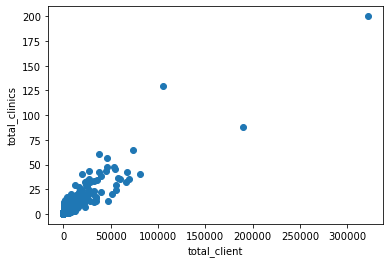

In [113]:
# Plot the data to see if a linear trend exists

### BEGIN SOLUTION
plt.scatter(X, y)
plt.xlabel(column1)
plt.ylabel(column2)
### END SOLUTION

In [116]:
# Use sklearn's `train_test_split` to split the data into training and testing
# Keep in mind that our group may want to use the model on an entirely different table as well. 

from sklearn.model_selection import train_test_split # may not apply to all models

### BEGIN SOLUTION 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### END SOLUTION

## Linear Regression

In [117]:
# Create the model

### BEGIN SOLUTION

from sklearn.linear_model import LinearRegression

model = LinearRegression()

### END SOLUTION

In [118]:
# Fit the model to the training data. 

### BEGIN SOLUTION

model.fit(X_train, y_train)

### END SOLUTION

LinearRegression()

In [119]:
# Calculate the mean_squared_error and the r-squared value
# for the testing data

from sklearn.metrics import mean_squared_error, r2_score

### BEGIN SOLUTION

# Use our model to make predictions
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### END SOLUTION

Mean Squared Error (MSE): 8.169788186692571
R-squared (R2 ): 0.8874859257921728


In [120]:
# Call the `score` method on the model to show the r2 score

### BEGIN SOLUTION
model.score(X_test, y_test)
### END SOLUTION

0.8874859257921728